# **Tarea Nº 4**
Scope: APIs

Curso:          Fundamentos de Programación en Python para Macroeconomía y Finanzas     
Profesor:       Victor Fuentes Campos     

- Fecha y hora de entrega: Viernes 12 de enero, 11:59pm
- Agregue los nombres de las personas con las que discutió esta tarea: Adriana Arce y Braulio Mundaca
- Envíe su tarea haciendo el `push` de su código a su repo en GitHub Classroom: 

The Central Bank Reserve of Perú (BCRP) holds a list of datasets that are among the most comprehensive for macroeconomic purposes. In this exercise, we'll retrieve data from the [BCRP API](https://estadisticas.bcrp.gob.pe/estadisticas/series/ayuda/api) and explore the impact of pandemics

## Before starting

- You must pull the necessary data using `get` and `requests`
- You are required to apply the concepts learned in the previous sessions (`pandas`, `if`, `loop`, `function`)
- Hint: here is the BCRP url structure for the APIs call:
```html
https://estadisticas.bcrp.gob.pe/estadisticas/series/api/[códigos de series]/[formato de salida]/[periodo inicial]/[periodo final]/[idioma]
```

## The very long run

1. Locate the "Estadísticas de 100 años del BCRP" section in the BCRP´s series data statistics [here](https://estadisticas.bcrp.gob.pe/estadisticas/series/index) and identify the necessary code for the serie **`PBI (Mill S/ 2007)`**. Later, add manually the annual GDP values for 2022 and 2023 (be careful with the units of data). Then, **calculate** the Peruvian annual GDP growth (%) since 1922 to 2023. Finally, plot it using a very simple graph through `matplotlib` and provide critical insights (no more than 100 words)

    Hint1: use `.json()` for exploring the `content`. Your data is inside `["periods"]`
    
    Hint2: the graph must looks something like this: <img src="growth_gdp_long_run.png" max-width="300">
    

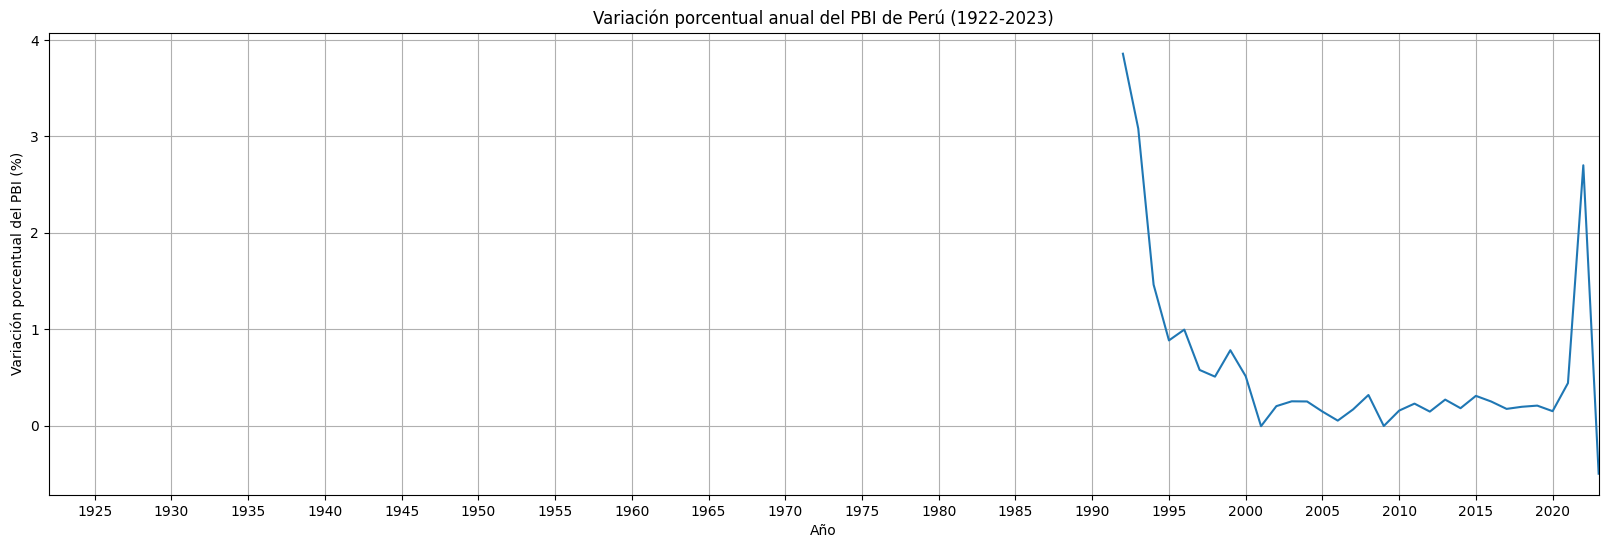

In [167]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Obtén los datos de la API
response = requests.get("https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PN01288PM/json/1921/2022/esp")
data = response.json()

# Extrae los datos del PBI
pbi_data = [{"year": item["name"], "value": float(item["values"][0])} for item in data["periods"]]

# Crea el DataFrame
df = pd.DataFrame(pbi_data)

# Crea un diccionario para mapear los nombres de los meses en español a inglés
month_map = {'Ene': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'Abr': 'Apr', 'May': 'May', 'Jun': 'Jun',
             'Jul': 'Jul', 'Ago': 'Aug', 'Set': 'Sep', 'Oct': 'Oct', 'Nov': 'Nov', 'Dic': 'Dec'}

# Reemplaza los nombres de los meses en la columna 'year'
df['year'] = df['year'].replace(month_map, regex=True)

# Calcula la variación porcentual y almacénala en una nueva columna 'pct_change'
df['var.'] = df['value'].pct_change()*100
df

#Incorporamos los datos del año 2022 y 2023
new_data = pd.DataFrame({
    'year': pd.to_datetime(['Dec.2022', 'Dec.2023'], format='%b.%Y'),  # Asegúrate de que las fechas estén en el mismo formato que tu DataFrame original
    'var.': [2.7, -0.5]  # Estos son los nuevos valores del PBI
})

# Une el nuevo DataFrame con el original
df = pd.concat([df, new_data]).reset_index(drop=True)

# Asegúrate de que la columna 'year' sea de tipo datetime
df['year'] = pd.to_datetime(df['year'], format='%b.%Y')

# Crea una nueva columna 'year_only' que contenga solo el año
df['year_only'] = df['year'].dt.year

# Agrupa los datos por año y calcula la media
df_yearly = df.groupby('year_only').mean() # Ahora df_yearly es un DataFrame que contiene la media anual de los datos
df_yearly

# Filtra los datos desde 1922 hasta 2021
df_yearly = df_yearly[(df_yearly.index >= 1922) & (df_yearly.index <= 2024)]
df_yearly

# Crea la figura y el eje
fig, ax = plt.subplots(figsize=(20, 6))

# Dibuja los datos
ax.plot(df_yearly.index, df_yearly['var.'])

# Configura el formato de las fechas en el eje x
years = mdates.YearLocator()   # cada año
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlim([1922, df_yearly.index.max()])

# Configura las etiquetas y el título
ax.set_xlabel('Año')
ax.set_ylabel('Variación porcentual del PBI (%)')
ax.set_title('Variación porcentual anual del PBI de Perú (1922-2023)')

# Muestra la cuadrícula
ax.grid(True)

# Muestra el gráfico
plt.show()


## The hitman

2. Retrieve the up-to-date data for the monthly GDP in index (2007=100) from this [link](https://estadisticas.bcrp.gob.pe/estadisticas/series/mensuales/producto-bruto-interno-y-demanda-interna-variaciones-indice-2007). Then, calculate the the 5-year average monthly growth previous to the pandemics (ending in Feb-2020) for the 12-month rolling mean of the index, and project the alternative scenario of the Peruvian economy without the COVID-19. Then plot them out and provide insight from the gap between the real data and the pre-pandemic trend.

    Hint1: You may use the regression type of your election, but the OLS is recommended. 
    
    Hint2: Your plot should look somethig like this. You aren´t required to add flags/annotations/texts inside the graph <img src="growth_gdp_pandemics.png" max-width="300">

    Hint3: For more details about calculation, review this post from [The Economist](https://www.economist.com/graphic-detail/2021/10/28/americas-post-covid-economic-recovery-suffers-a-setback)
    


In [169]:
# Solution

## The winners

- Based on the [Nasdaq Stock Screener](https://www.nasdaq.com/market-activity/stocks/screener), identify the three largest companies in the three larger sectors defined by market cap
- Elaborate a list/dictionary/series (what ever you think is more suitable) containing all tickers (or symbols) and sectors from these companies.
- So far, you can download data from Nasdaq, web scrape it or copy it manually. It doesn´t matter
- Then, use `yfinance` library to retrieve the market data for all the 9 firms
- Construct a table with the most common *institucional holders* by sector. Is there any interesting pattern? Hint: loop the `institutional_holders` from `yfinance`
- Calculate the distribution of the daily percentage returns for the 3 larger companies (defined by market cap) along the last 5 years. Plot your results (feel free to find the most appealing way to represent them) and provide critical insights

$$
  percentage\_return_{t} = \frac{price_t-price_{t-1}}{price_t}*100+dividends (\%)
$$

- Hint1: you can find the `dividens` through the `yfinance`'s 
`Ticker()`
- Hint2: some firms may not be paying dividends

In [170]:
# Solution